Since I can't recreate this [R2RT](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html) blog post results with `tf.contrib.layers.batch_norm`, I decided to make a second notebook which will follow closely with the implementation in the code.

Let's see how far I can go!

\* You can find the details about batch normalization in this [paper](https://arxiv.org/pdf/1502.03167v3.pdf) if you don't know what it is.

In [4]:
%matplotlib inline
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
mnist = input_data.read_data_sets("data", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


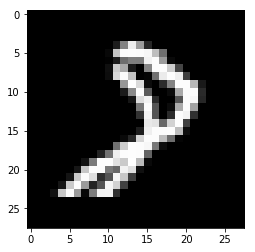

In [6]:
print(mnist.train.labels[3690])
plt.imshow(mnist.train.images[3690].reshape((28, 28)), cmap='gray', interpolation=None)

In [10]:
def batch_norm_wrapper(inputs, is_training=True, decay=0.999, epsilon=1e-5):
    """
    batch_norm_wrapper
    
    Create a batch normalize layers
    
    params
    ======
    - inputs <Tensor>: input Tensor
    - is_training <bool>: running in training mode (True by default)
    - decay <float>: decay rate of the exponentail moving averages
    
    returns
    =======
    - outputs: batch normalized output
    """
    N_features = inputs.get_shape()[-1]
    
    # Trainable variables for batch normalization
    gamma = tf.Variable(tf.ones(N_features), 
                        dtype=tf.float32)
    beta = tf.Variable(tf.zeros(N_features),
                       dtype=tf.float32)
    # non-trainable variables. Make sure it will not be
    # updated with optimizer
    moving_mean = tf.Variable(tf.zeros(N_features),
                              trainable=False,
                              dtype=tf.float32)
    moving_var = tf.Variable(tf.ones(N_features),
                             trainable=False,
                             dtype=tf.float32)
    if is_training:
        train_mean, train_var = tf.nn.moments(inputs, [0])
        update_mean_op = tf.assign(moving_mean, 
                                   decay*moving_mean+(1-decay)*train_mean)
        update_var_op = tf.assign(moving_var,
                                  decay*moving_var+(1-decay)*train_var)
        with tf.control_dependencies([update_mean_op, update_var_op]):
            # use tf.control_dependencies to make sure that update_mean_op and
            # update_var_op will be executed before the evaluation of outputs
            outputs = tf.nn.batch_normalization(inputs, 
                                                train_mean, 
                                                train_var, 
                                                beta, 
                                                gamma, 
                                                epsilon)
    else:
        # Here we will get the moving average mean an variance from restored 
        # session. That is, it will normalized inputs with the moving average
        # learned from training session
        outputs = tf.nn.batch_normalization(inputs,
                                            moving_mean,
                                            moving_var,
                                            beta,
                                            gamma,
                                            epsilon)
    return outputs

In [19]:
w1_init = np.random.normal(size=(784, 100)).astype(np.float32)
w2_init = np.random.normal(size=(100, 100)).astype(np.float32)
w3_init = np.random.normal(size=(100, 10)).astype(np.float32)

In [35]:
def build_graph(graph, is_training=True):
    with graph.as_default():
        x_ = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        
        # layer 1
        W1 = tf.Variable(w1_init, dtype=tf.float32)
        z1 = tf.matmul(x_, W1)
        l1 = tf.nn.sigmoid(batch_norm_wrapper(z1, is_training=is_training))
        
        # layer 2
        W2 = tf.Variable(w2_init, dtype=tf.float32)
        z2 = tf.matmul(l1, W2)
        l2 = tf.nn.sigmoid(batch_norm_wrapper(z2, is_training=is_training))
        
        # layer 3
        W3 = tf.Variable(w3_init, dtype=tf.float32)
        z3 = tf.matmul(l2, W3)
        y = tf.nn.softmax(z3)
        predict = tf.arg_max(y, 1)
        
        loss = -tf.reduce_sum(y_*tf.log(y))
        train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
        
        saver = tf.train.Saver()
    return x_, y_, predict, loss, train_op, saver

In [42]:
def compute_accuracy(y1, y2):
    return 100*(y1 == y2).mean()

In [40]:
n_iteration = 10000
batch_size=100

In [47]:
train_graph = tf.Graph()
x_, y_, predict, loss, train_op, saver = build_graph(train_graph, True)

with tf.Session(graph=train_graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iteration):
        train_images, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = {x_:train_images,
                     y_:train_labels}
        _, l = sess.run([train_op, loss], feed_dict=feed_dict)
        if (step+1) % 1000 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(mnist.test.labels, 1))
            print("Iteration {}: {} {:.2f}%".format(step+1, l, acc))
    saver.save(sess, "models/batch_norm")

Iteration 1000: 33.61806869506836 90.60%
Iteration 2000: 30.719919204711914 92.12%
Iteration 3000: 15.241762161254883 93.32%
Iteration 4000: 11.810280799865723 93.99%
Iteration 5000: 17.605941772460938 94.54%
Iteration 6000: 9.061473846435547 94.89%
Iteration 7000: 7.425298690795898 95.05%
Iteration 8000: 7.866730690002441 95.47%
Iteration 9000: 11.218859672546387 95.71%
Iteration 10000: 6.200161933898926 95.84%


In [51]:
predict_graph = tf.Graph()
x_, y_, predict, _, _, saver = build_graph(predict_graph, False)

with tf.Session(graph=predict_graph) as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "models/batch_norm")
    
    feed_dict = {x_: mnist.test.images,
                 y_: mnist.test.labels}
    pred = sess.run(predict, feed_dict=feed_dict)
    acc = compute_accuracy(pred, np.argmax(mnist.test.labels, 1))
    print("Accuracy in reference phase: {:.2f}%".format(acc))

INFO:tensorflow:Restoring parameters from models/batch_norm
Accuracy in reference phase: 95.82%


Wow....It works. I'll dig into the source codes for both `tf.nn.batch_normalize` and `tf.contrib.layers.batch_norm` to see what goes wrong there (maybe?)